# 3D Gaussian Splatting for Real-Time Radiance Field Rendering (SIGGRAPH 2023)

arXiv - https://arxiv.org/abs/2308.04079

## 0. What is 3D Gaussian Splatting?

In page 4 of the paper,

> *We Choose 3D Gaussians, which are differentiable and can be easily projected to 2D Splats allowing fast alpha-blending or rendering.*

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/overview.JPG" alt="Overview of 3D Gaussian Splatting">
</div>

## 1. Preprocess the Dataset

### 1.1 Download the NeRF-synthetic Dataset

> The paper uses 3 datasets, NeRF-synthetic dataset, Mip-NeRF 360 dataset, and Tanks&Templates dataset.

We will start with NeRF-synthetic dataset that are easy to access.

In [ ]:
from pathlib import Path
import gdown

# Setup dataset folder
dataset_path = Path("datasets/")

# Check if the dataset folder exists, and if not, download the dataset.
if dataset_path.is_dir():
  print(f"[INFO] {dataset_path} already exists.")
else:
  print(f"[INFO] Cannot find {dataset_path}, creating the directory...")
  dataset_path.mkdir(parents=True, exist_ok=True)

[INFO] Cannot find datasets, creating the directory...


In [ ]:
!gdown "https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g" -O "./datasets/nerf_synthetic.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g
From (redirected): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g&confirm=t&uuid=f587bd8d-7d12-4fd2-8891-fc9d162ccb40
To: /content/datasets/nerf_synthetic.zip
100% 1.27G/1.27G [00:26<00:00, 48.5MB/s]


In [ ]:
import zipfile

# Unzip NeRF_Synthetic dataset
with zipfile.ZipFile(dataset_path / "nerf_synthetic.zip", "r") as zip_ref:
  print("[INFO] Unzipping nerf_synthetic dataset...")
  zip_ref.extractall(dataset_path)

# Delete existing compressed dataset file
!rm "./datasets/nerf_synthetic.zip"

[INFO] Unzipping nerf_synthetic dataset...


### 1.2 Explore the NeRF-synthetic dataset


Stats:
+ 8 Scenes -  ***(chair, drums, ficus, hotdog, lego, materials, mic, ship)***
+ 100 Training images
+ 100 Validation images
+ 200 Test images
+ Images are 800x800

Structure:
  * SCENE_NAME
    * train
      * r_num.png
    * val
      * r_num.png
    * test
      * r_num.png
      * r_num_depth_0000.png
      * r_num_normal_0000.png
    * transforms_train.json
    * transforms_val.json
    * transforms_test.json

Transform json details:
  * camera_angle_x: The FOV in x dimension
  * frames: List of dictionaries that contain the camera transform matrices for each image.


Random image path: datasets/nerf_synthetic/materials/test/r_132.png
Image Height * Width : 800 * 800


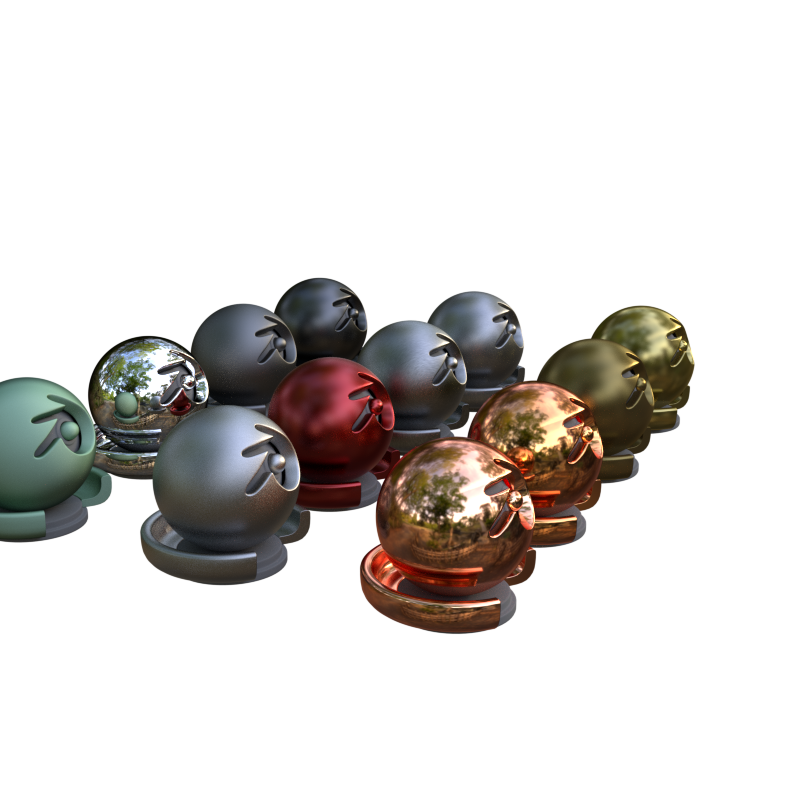

In [ ]:
import random
from PIL import Image

# Get All Image Paths
nerf_synthetic_path = dataset_path / "nerf_synthetic"
image_path_list = list(nerf_synthetic_path.glob("*/*/*.png"))

# Get Random Image Path
random_image_path = random.choice(image_path_list)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Height * Width : {img.height} * {img.width}")
img

### ***(Optional)*** 1.3 Make SfM (Structure-from-Motion) points from NeRF-synthetic dataset



**Note:** The below process takes a long time, so you can skip to **1.4 Download SfM points from HuggingFace**

In [ ]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 116.5 MB/s eta 0:00:00


```python
from pathlib import Path
import pycolmap
from pycolmap import logging
import shutil

def make_SfM_points(image_path: Path, category: str):
  """
  Args:
    image_path : pathlib.Path
    category : str - (e.g, chair, drums, ficus, hotdog, lego, materials, mic, ship)
  """
  output_path = Path("COLMAP/")
  category_path = output_path / category

  category_path.mkdir(parents=True, exist_ok=True)
  logging.set_log_destination(logging.INFO, output_path / "logs")

  database_path = category_path / "database.db"
  sfm_path = category_path / "sfm"

  print(f"[INFO] Processing category: {category}")
  if database_path.exists():
    database_path.unlink()

  pycolmap.extract_features(database_path, image_path)
  pycolmap.match_exhaustive(database_path)

  num_images = pycolmap.Database(database_path).num_images
  print(f"[INFO] Found {num_images} images in {category} dataset.")

  if sfm_path.exists():
    shutil.rmtree(sfm_path)
  sfm_path.mkdir(exist_ok=True)

  records = pycolmap.incremental_mapping(database_path, image_path, sfm_path)

  for idx, record in records.items():
    logging.info(f"#{idx} {record.summary}")

  print(f"[INFO] SfM completed for {category}.")
```

```python
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]

for category in categories:
  image_path = nerf_synthetic_path / category / "train"
  make_SfM_points(image_path, category)
```

### 1.4 Download SfM points from HuggingFace

- The dataset created in process 1.3 was uploaded to huggingface. - https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points

- Follow the below process and unzip the compressed file to a specified path.

In [ ]:
!wget -q https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points/resolve/main/NeRF_synthetic_SfM_points.zip
!unzip -q NeRF_synthetic_SfM_points.zip -d COLMAP/
!rm -rf NeRF_synthetic_SfM_points.zip


### 1.5 Visualize SfM points from NeRF-synthetic dataset

In [ ]:
!pip install -q open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pycolmap
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

def create_SfM_points(sfm_path: Path):
  category = sfm_path.parent.stem
  reconstruction = pycolmap.Reconstruction(sfm_path)
  # Collect 3D points
  points = []
  colors = []

  for point3D in reconstruction.points3D.values():
    points.append(point3D.xyz)
    colors.append(point3D.color / 255.)

  points = np.array(points)
  colors = np.array(colors)

  print(f"[INFO] {category} points shape : {points.shape} | colors shape : {colors.shape}")

  return points, colors, category

def visualize_SfM_points(points, colors, category):
  """ Visualize the SfM points using Open3D.

  Args:
    points:
    colors:
    category:
  """
  # Create open3d point cloud
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)

  # Visualize the point cloud
  print(f"[INFO] Visualizing {category} {len(points)} points...")

  fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
  )
  fig.show()

In [ ]:
import random
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]
use_random = False
if use_random:
  selected_category = random.choice(categories)
  sfm_path = Path("COLMAP/") / selected_category / Path("sfm/0")
else:
  sfm_path = Path("COLMAP/hotdog/sfm/0")
points, colors, category = create_SfM_points(sfm_path)
visualize_SfM_points(points, colors, category)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)
[INFO] Visualizing sfm 8261 points...


You can visualize point clouds like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/SfM Points.png" alt="SfM Points">
</div>

## 2. Initialization




### 2.1 Create a set of 3D Gaussians

In page 4 of the paper,

> From these points we create a set of 3D Gaussians defined by a position (mean), covariance matrix and opacity $\alpha$

> Our Gaussians are defined by a full 3D covariance matrix $\Sigma$ defined in world space centered at point (mean) $\mu$

$$ G(x)=e^{-\frac{1}{2}(x)^T \Sigma^{-1}(x)}$$



In [ ]:
from pathlib import Path
import numpy as np
from scipy.stats import multivariate_normal
from typing import Dict
import plotly.graph_objects as go


def create_3D_Gaussians(points, colors, grid_size:int=100) -> Dict[str, np.array]:
  """ Create a set of 3D Gausssians.

  Args:
    sfm_path: Path to the SfM folder containing the COLMAP outputs.
  """

  points, colors, _ = create_SfM_points(sfm_path)

  # Calculate the mean
  mu = np.mean(points, axis=0)

  # Calculate the covariance matrix
  covariance_matrix = np.cov(points, rowvar=False)

  # Define the grid range
  x_range = np.linspace(points[:, 0].min(), points[:, 0].max(), grid_size)
  y_range = np.linspace(points[:, 1].min(), points[:, 1].max(), grid_size)
  z_range = np.linspace(points[:, 2].min(), points[:, 2].max(), grid_size)

  # Create a 3D grid
  x, y, z = np.meshgrid(x_range, y_range, z_range)
  grid_points = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=1)

  # Create a multivariate Gaussian distribution
  gaussian = multivariate_normal(mean=mu, cov=covariance_matrix)

  # Reshape PDF values to match the grid
  pdf_values = gaussian.pdf(grid_points).reshape(x.shape)

  return  {
      "pdf_values": pdf_values,
      "x_range": x_range,
      "y_range": y_range,
      "z_range": z_range
  }

def visualize_3D_Gaussians(data: Dict[str, np.array]):

  pdf_values = data["pdf_values"]
  x_range = data["x_range"]
  y_range = data["y_range"]
  z_range = data["z_range"]

  # Generate Plotly Volume plot
  fig = go.Figure(data=go.Volume(
      x=np.repeat(x_range, len(y_range) * len(z_range)),
      y=np.tile(np.repeat(y_range, len(z_range)), len(x_range)),
      z=np.tile(z_range, len(x_range) * len(y_range)),
      value=pdf_values.ravel(),
      isomin=pdf_values.min(),
      isomax=pdf_values.max(),
      opacity=0.1,
      surface_count=10,
      colorscale="Viridis"
  ))

  # Setup plot
  fig.update_layout(
      scene=dict(
          xaxis_title="X",
          yaxis_title="Y",
          zaxis_title="Z",
          aspectmode="cube"
      ),
      title="3D Gaussian Visualization"
  )

  fig.show()

In [ ]:
gaussian_data = create_3D_Gaussians(points, colors)
# visualize_3D_Gaussians(gaussian_data)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)


You can visualize the 3D Gaussian like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/3D Gaussian.png" alt="3D Gaussian">
</div>

## 3. Projection




### 3.1 Operation Flow of Projection

In page 4 of the paper,
* $W$ - Viewing transform matrix
* $J$ - Jacobian of the affine approximation of the projective transform
* $\Sigma^{\prime}$ - Covariance matrix in view space

$$ \Sigma^{\prime}=J W \Sigma W^T J^T $$

* $\Sigma$ - Covariance matrix in world space

**Note**: $\Sigma$ has physical meaning only when they are positive semi-definite.


$$ \Sigma=R S S^T R^T$$

* $R$ - Rotation matrix
  * $q$ - a quaternion to represent rotation
* $S$ - Scaling matrix
  * $s$ - a 3D vector for scaling

**Note:** To update the parameters of the covariance matrix using gradient descent, the optimized representation above was adopted to ensure that the covariance matrix remains positive semi-definite.

---
Now we need to use **PyTorch**.

In [ ]:
# Make device-agnostic code in PyTorch
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
q = torch.nn.Parameter(data=torch.randn((1, 4))).to(device)

print(f"q in device : {q.device}")
print(f"q shape : {q.shape}")

q in device : cuda:0
q shape : torch.Size([1, 4])


<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 10.JPG" alt="Quaternion to Rotation Matrix">
</div>

In [ ]:
from scipy.spatial import KDTree
import torch
import numpy as np

def distCUDA2(points: np.ndarray, device: torch.device=device):
  """
    Calculates the average squared distance to the 3 nearest neighbors
    for each point in a point cloud using a KDTree.

    Args:
        points (np.ndarray): Input point cloud with shape (N, 3),
            where N is the number of points, and each point has 3 coordinates (x, y, z).
        device (torch.device, optional): The target device (e.g., 'cuda' or 'cpu')
            where the resulting tensor will be stored. Defaults to `device`.

    Returns:
        torch.Tensor: A 1D tensor of shape (N,) containing the average squared distances
            to the 3 nearest neighbors for each point.

  Notes:
    In source code, they use `from simple_knn._C import distCUDA2`.
    This version re-implements the functionality purely using PyTorch and SciPy,
          based on a solution by @rfeinman (see https://github.com/graphdeco-inria/gaussian-splatting/issues/292).
  """
  dists, indices = KDTree(points).query(points, k=4)
  meanDists = (dists[:, 1:] ** 2).mean(1)

  return torch.tensor(meanDists, device=device)

In [ ]:
import torch
import numpy as np

def make_rotation_matrix(q: torch.Tensor, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    q - quaternion, a tensor with shape (1, 4)
    device - torch.device, "cuda" or "cpu"
  Returns:
    R - Rotation matrix, a tensor with shape (3, 3)
  """
  q_r, q_i, q_j, q_k = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

  if device == "cuda":
    R = torch.zeros((3, 3), device="cuda")
  elif device == "cpu":
    R = torch.zeros((3, 3), device="cpu")

  R[0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
  R[1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
  R[2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

  R[0, 1] = 2 * (q_i * q_j - q_r * q_k)
  R[1, 0] = 2 * (q_i * q_j + q_r * q_k)

  R[0, 2] = 2 * (q_i * q_k + q_r * q_j)
  R[2, 0] = 2 * (q_i * q_k - q_r * q_j)

  R[1, 2] = 2 * (q_j * q_k - q_r * q_i)
  R[2, 1] = 2 * (q_j * q_k + q_r * q_i)

  return R

def make_scaling_matrix(points: np.array, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    points - derived from SfM point cloud, should be in CUDA
    device - torch.device, "cuda" or "cpu"
  Returns:
    S - Scaling matrix, a tensor with shape (3, 3)

  """

  points_distances = torch.clamp(distCUDA2(points).float().to(device), min=1e-7)
  print(f"points_distances shape : {points_distances.shape}")

  scale_factors = torch.log(torch.sqrt(points_distances)).mean(dim=0)

  S = torch.full((3, 3), scale_factors, device=device)
  print(f"S shape : {S.shape}")
  return S

def calc_covariance_matrix (R : torch.Tensor, S: torch.Tensor) -> torch.Tensor:
  """
  Args:
    R - Rotation matrix, a tensor with shape (3, 3)
    S - Scaling matrix, a tensor with shape (3, 3)
  Returns:
    SIGMA - Covariance matrix, a tensor with shape (3, 3)
  """

  RS = (R @ S)
  SIGMA = RS @ RS.T

  return SIGMA

In [ ]:
R = make_rotation_matrix(q)

S = make_scaling_matrix(points)

print(S)
print(S.shape)

points_distances shape : torch.Size([8261])
S shape : torch.Size([3, 3])
tensor([[-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898]], device='cuda:0')
torch.Size([3, 3])


### 3.2 Create a Gaussian Model - Version 1

In order to implement the operation flow and gradient flow of the paper,

a model which can perform forward and backward operations is needed.

---

In page 13 of the paper,

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 1-1.JPG" alt="Algorithm 1-1">
</div>


In [ ]:
import torch

def inverse_sigmoid(x: torch.Tensor):
  return torch.log(x / (1-x))

In [ ]:
from torch import nn
import numpy as np

class GaussianSplattingModelV1(nn.Module):
  def __init__(self, points, colors):

    super().__init__()

    points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities = self.initialize_from_gaussians(points, colors)

    self.xyz = nn.Parameter(points_to_tensor, requires_grad=True)
    self.features_diffuse_color = nn.Parameter(features_diffuse_color, requires_grad=True)
    self.features_rest = nn.Parameter(features_rest, requires_grad=True)
    self.quaternions = nn.Parameter(quaternions, requires_grad=True)
    self.scaling_vectors = nn.Parameter(scaling_vectors, requires_grad=True)
    self.opacities = nn.Parameter(opacities, requires_grad=True)

    # self.update_covariances()

    self.set_activation_functions()

  def update_covariances(self):
    self.covariances = calc_covariance_matrix(make_rotation_matrix(self.quaternions), make_scaling_matrix(self.scaling_vectors))

  def initialize_from_gaussians(self, points, colors, max_sh_degree=3, C0=0.28209479177387814):
    # Conver numpy array of points to torch.Tensor
    points_to_tensor = torch.tensor(np.asarray(points), device=device)

    # Conver numpy array of colors to torch.Tensor and simultaneously convert RGB to Spherical Harmonics coefficients.
    colors_to_SH = (torch.tensor(np.asarray(colors), device=device) - 0.5) / C0
    features = torch.zeros((colors_to_SH.shape[0],  3, (max_sh_degree + 1) ** 2), device=device)

    features[:, :3, 0] = colors_to_SH
    features[:, 3:, 1:] = 0.

    features_diffuse_color = features[:, :, 0:1].transpose(1, 2).contiguous()
    features_rest = features[:, :, 1:].transpose(1, 2).contiguous()

    quaternions = torch.zeros((points_to_tensor.shape[0], 4), device=device)
    quaternions[:, 0] = 1

    distances = torch.clamp_min(distCUDA2(points), 1e-7)
    scaling_vectors = torch.log(torch.sqrt(distances)).unsqueeze(-1).expand(-1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((points_to_tensor.shape[0], 1), device=device))

    return points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities

  def set_activation_functions(self, opacity_activation=torch.sigmoid, covariance_scale_activation=torch.exp):
    self.opacity_activation = opacity_activation
    self.covariance_scale_activation = covariance_scale_activation


  def print_model_parameters(self):
    print(f"{'Parameter Name':<30} {'Shape':<30} {'Trainable':<10}")
    print("-" * 70)
    for name, param in self.named_parameters():
        print(f"{name:<30} {str(list(param.shape)):<30} {param.requires_grad}")

  def forward(self, x:torch.Tensor):
    return self.xyz, self.features_diffuse_color, self.features_rest, self.quaternions, self.scaling_vectors, self.opacities

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

GSM_V1 = GaussianSplattingModelV1(points=points,
                                  colors=colors)

summary(model=GSM_V1,
        input_size=points.shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Couldn't find torchinfo... installing it.


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
GaussianSplattingModelV1 (GaussianSplattingModelV1)     [8261, 3]            [8261, 3]            487,399              True
Total params: 487,399
Trainable params: 487,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.10
Forward/backward pass size (MB): 0.40
Params size (MB): 2.15
Estimated Total Size (MB): 2.64

In [ ]:
GSM_V1.print_model_parameters()

Parameter Name                 Shape                          Trainable 
----------------------------------------------------------------------
xyz                            [8261, 3]                      True
features_diffuse_color         [8261, 1, 3]                   True
features_rest                  [8261, 15, 3]                  True
quaternions                    [8261, 4]                      True
scaling_vectors                [8261, 3]                      True
opacities                      [8261, 1]                      True


### 3.3 Optimization

In page 8 of the paper,

> For stability, we "warm-up" the computation in lower resolution. Specifically, we start the optimization using 4 times smaller image resolution and we upsample twice after 250 and 500 iterations.

In page 8 of the paper,

> We start by optimizing only the zero-order component of the SH, and then introduce one band of the SH after every 1000 iterations until all 4 bands of SH are represented.

In page 5 of the paper,
> We use a standard exponential decay scheduling technique similar to Plenoxels, but for positions only.

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 7.JPG" alt="Loss Equation">
</div>

In [ ]:
import torch
from math import exp
import torch.nn.functional as F

def L1_Loss(network_output, ground_truth):
    return torch.abs((network_output - ground_truth)).mean()

def gaussian(window_size: int,
             sigma: float):
  """
  Generates a list of Tensor values drawn from a gaussian distribution with standard deviation.
  """
  gauss = torch.Tensor([exp(-(x - window_size // 2) **2 / float(2 * sigma ** 2)) for x in range(window_size)])
  return gauss / gauss.sum()

def create_window(window_size: int,
                  channel: int=1):

  # _1d_window : (window_size, 1)
  _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)

  # _2d_window : (window_size, window_size)
  _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)

  # window : (channel, 1, window_size, window_size)
  window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

  return window

def ssim(img1, img2, window_size=11, size_average=True):

  try:
    _, channel, height, width = img1.size()
  except:
    channel, height, width = img1.size()

  window = create_window(window_size=window_size, channel=channel)

  if img1.is_cuda:
    window = window.cuda(img1.get_device())
  window = window.type_as(img1)

  mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
  mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

  sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1.pow(2)
  sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2.pow(2)
  sigma_1_2 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu_1 * mu_2

  C1, C2 = 0.01 **2, 0.03 ** 2

  ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma_1_2 + C2)) / ((mu1.pow(2) + mu2.pow(2) + C1) * (sigma1_sq + sigma2_sq + C2))

  if size_average:
    return ssim_map.mean()
  else:
    return ssim_map.mean(1).mean(1).mean(1)

def psnr(img1, img2):
  mse = (((img1 - img2)) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)
  return 20 * torch.log10(1. / torch.sqrt(mse))

In [ ]:
LAMBDA = 0.2 # hyperparameter of the loss

# loss = (1 - LAMBDA) * torch.nn.L1Loss(pred_image, src_image) + LAMBDA * ssim(pred_image, src_image)

In [ ]:
### Modified and Restructured from PleNoxels Soruce Code ###
  def exponential_learning_rate_function(lr_init, lr_final, lr_delay_steps=0, lr_delay_multiplier=1., max_steps=1_000_000):
    def internal_process_learning_rate(step):
      if step < 0 or (lr_init == 0. and lr_final == 0.):
        return 0.
      if lr_delay_steps > 0:
        delay_rate = lr_delay_multiplier + (1 - lr_delay_multiplier) * np.sin(0.5 * np.pi * np.clip(step / lr_delay_steps, 0, 1))
      else:
        delay_rate = 1.
      timestep = np.clip(step / max_steps, 0, 1)
      log_interpolation = np.exp(np.log(lr_init) * (1 - timestep) + np.log(lr_final) * timestep)
      return delay_rate * log_interpolation
    return internal_process_learning_rate

## 4. Adaptive Density Control

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 1-3.JPG" alt="Algorithm 1-3">
</div>

In page 5 of the paper,

> After optimization warm-up, we densify every 100 iterations and remove any Gaussians that are essentially transparent, i.e., with $\alpha$ less than a threshold $\epsilon_{\alpha}$.

In page 14 of the paper,

> We skip any blending updates with $\alpha < \epsilon$ (we choose $\epsilon$ as 1/255) and also clamp $\alpha$ with 0.99 from above.  

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/figure 4.JPG" alt="Adaptive Gaussian Densification Scheme">
</div>

In page 5 of the paper,
> We observe that both (under-reconstruction and over-reconstruction) have large view-space positional gradients.

> We densify Gaussians with magnitude of view-space position gradients above a threshold $\tau_{pos}$.

> ... in under-reconstructed regions, ... clone the Gaussians, by simply creating a copy of the same size, and move it in the direction of the positional gradient.

> ... large Gaussians in regions with high variance need to be split into smaller Gaussians. We replace such Gaussians by two new ones, and divide their scale by factor of $\phi$

### 4.1 Create a Gaussian Model - Version 2


In [ ]:
from torch import nn
import numpy as np
import os
from plyfile import PlyData, PlyElement

### Modified and Restructured from Gaussian Splatting Source Code ###
class GaussianSplattingModelV2(nn.Module):
  def __init__(self,
               points: torch.Tensor,
               colors: torch.Tensor,
               camera_infos: dict,
               optimizer: torch.optim=torch.optim.Adam,
               iterations: int=7_000):

    super().__init__()

    points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities, max_radii = self.initialize_from_gaussians(points, colors)

    self.xyz = nn.Parameter(points_to_tensor, requires_grad=True)
    self.features_diffuse_color = nn.Parameter(features_diffuse_color, requires_grad=True)
    self.features_rest = nn.Parameter(features_rest, requires_grad=True)
    self.quaternions = nn.Parameter(quaternions, requires_grad=True)
    self.scaling_vectors = nn.Parameter(scaling_vectors, requires_grad=True)
    self.opacities = nn.Parameter(opacities, requires_grad=True)
    self.max_radii = nn.Parameter(max_radii, requires_grad=True)

    self.camera_infos = camera_infos

    # self.update_covariances()

    self.set_activation_functions()

    self.initialize_optimization_params(optimizer)

    self.iterations = iterations

    self.set_learning_rate_schedulers(iterations)

  def update_covariances(self):
    self.covariances = calc_covariance_matrix(make_rotation_matrix(self.quaternions), make_scaling_matrix(self.scaling_vectors))

  def initialize_from_gaussians(self, points, colors, max_sh_degree=3, C0=0.28209479177387814):
    # Conver numpy array of points to torch.Tensor
    points_to_tensor = torch.tensor(np.asarray(points), device=device)

    # Conver numpy array of colors to torch.Tensor and simultaneously convert RGB to Spherical Harmonics coefficients.
    colors_to_SH = (torch.tensor(np.asarray(colors), device=device) - 0.5) / C0
    features = torch.zeros((colors_to_SH.shape[0],  3, (max_sh_degree + 1) ** 2), device=device)

    features[:, :3, 0] = colors_to_SH
    features[:, 3:, 1:] = 0.

    features_diffuse_color = features[:, :, 0:1].transpose(1, 2).contiguous()
    features_rest = features[:, :, 1:].transpose(1, 2).contiguous()

    quaternions = torch.zeros((points_to_tensor.shape[0], 4), device=device)
    quaternions[:, 0] = 1

    distances = torch.clamp_min(distCUDA2(points), 1e-7)
    scaling_vectors = torch.log(torch.sqrt(distances)).unsqueeze(-1).expand(-1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((points_to_tensor.shape[0], 1), device=device))

    max_radii = torch.zeros((points_to_tensor.shape[0]), device=device)

    return points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities, max_radii

  def set_activation_functions(self,
                               opacity_activation=torch.sigmoid,
                               covariance_scale_activation=torch.exp,
                               scaling_split_activation=torch.log):
    self.opacity_activation = opacity_activation
    self.covariance_scale_activation = covariance_scale_activation
    self.scaling_split_activation = scaling_split_activation

  def initialize_optimization_params(self, optimizer: torch.optim):

    self.xyz_graidents = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)

    param_groups = [
        {'params': [self.xyz], 'lr': 1.6e-4, 'name': 'positions'},
        {'params': [self.features_diffuse_color], 'lr': 2.5e-3, 'name': 'features_diffuse_color'},
        {'params': [self.features_rest], 'lr': 2.5e-3, 'name': 'features_dc'},
        {'params': [self.quaternions], 'lr': 1e-3, 'name': 'rotations'},
        {'params': [self.opacities], 'lr': 2.5e-2, 'name': 'opacities'},
        {'params': [self.scaling_vectors], 'lr': 5e-3, 'name': 'scales'},
    ]

    self.optimizer = optimizer(params=param_groups, lr=0.)

    exposure = torch.eye(3, 4, device=device).unsqueeze(0).repeat(len(self.camera_infos), 1, 1)
    self.exposure = nn.Parameter(exposure, requires_grad=True)
    self.exposure_optimizer = torch.optim.Adam([self.exposure])

  def set_learning_rate_schedulers(self,
                              position_lr_init: float=1.6e-4,
                              position_lr_final: float=1.6e-6,
                              position_lr_delay_multiplier: float=1e-2,
                              exposure_lr_init: float=1e-2,
                              exposure_lr_final: float=1e-3,
                              exposure_lr_delay_steps: int=0,
                              exposure_lr_delay_multiplier: float=0.,
                              max_steps: int=7_000):
    self.xyz_scheduler = exponential_learning_rate_function(
        lr_init=position_lr_init,
        lr_final=position_lr_final,
        lr_delay_multiplier=position_lr_delay_multiplier,
        max_steps=max_steps)

    self.exposure_scheduler = exponential_learning_rate_function(
        lr_init=exposure_lr_init,
        lr_final=exposure_lr_final,
        lr_delay_steps=exposure_lr_delay_steps
        lr_delay_multiplier=exposure_lr_delay_multiplier,
        max_steps=iterations)

  def update_learning_rate(self):
    for param_group in self.exposure_optimizer.param_groups:
      param_group["lr"] = self.exposure_scheduler(self.iterations)

    for param_group in self.optimizer.param_groups:
      if param_group["name"] == "positions":
        lr = self.xyz_scheduler(self.iterations)
        param_group["lr"] = lr
        return lr

  ### Updated from V1 to V2 - 1. remove_gaussian() ###
  def remove_gaussian(self, epsilon_alpha=1/255, radius_threshold=20):
    """ Removes any gaussians that are essentially transparent with alpha less than a threshold."""
    is_transparent = (self.opacities < epsilon_alpha).squeeze()
    is_too_large_radius = self.max_radii > radius_threshold
    remove_mask = torch.logical_and(~is_transparent, ~is_too_large_radius)

    optimizable_tensors = {}
    for group in self.optimizer.param_groups:
      stored_state = self.optimizer.state.get(group['params'][0], None)
      if stored_state is None:
        group["params"][0] = nn.Parameter(group["params"][0][remove_mask], requires_grad=True)
        optimizable_tensors[group["name"]] = group["params"][0]
      else:
        stored_state["1st_momentum"] = stored_state["1st_momentum"][remove_mask]
        stored_state["2nd_momentum"] = stored_state["2nd_momentum"][remove_mask]

        del self.optimizer.state[group["params"][0]]
        group["params"][0] = nn.Parameter(group["params"][0][remove_mask], requires_grad=True)
        self.optimizer.state[group["params"][0]] = stored_state

        optimizable_tensors[group["name"]] = group["params"][0]

    self.xyz = optimizable_tensors["xyz"]
    self.features_diffuse_color = optimizable_tensors["features_diffuse_color"]
    self.features_rest = optimizable_tensors["features_rest"]
    self.opacities = optimizable_tensors["opacities"]
    self.scaling_vectors = optimizable_tensors["scaling_vectors"]
    self.quaternions = optimizable_tensors["quaternions"]
    self.xyz_gradients = self.xyz_gradients[remove_mask]
    self.denominator = self.denominator[remove_mask]
    self.max_radii = self.max_radii[remove_mask]

  ### Updated from V1 to V2 - 3. clone_gaussian() ###
  def clone_gaussian(self, tau_pos=2e-4, percent_dense=1e-2, scene_extent=0.):
    # Calculate Normalized Gradient Vectors
    grads = self.xyz_gradients / self.denominator
    grads[grads.isnan()] = 0.
    # Distinguish Gaussians to be cloned with a threshold, tau_pos
    clone_mask = torch.where(torch.norm(grads, dim=-1) >= tau_pos, True, False)

    ## Why use scene_extent?
    # 1. Avoid issues with outliers in the initial point cloud
    # 2. Adjust the learning rate relative to the scene size
    # 3. Balance between coordinate range and physical scene size
    if scene_extent:
        clone_mask = torch.logical_and(clone_mask,
                                       torch.max(self.scaling_vectors, dim=1).values <= percent_dense * (scene_extent if scene_extent else 1))

    masked_tensors = {
      "xyz": self.xyz[clone_mask],
      "features_diffuse_color": self.features_diffuse_color[clone_mask],
      "features_rest": self.features_rest[clone_mask],
      "opacities": self.opacities[clone_mask],
      "scaling_vectors": self.scaling_vectors[clone_mask],
      "quaternions": self.quaternions[clone_mask]
    }

    clone_tensors = {}
    for group in self.optimizer.param_groups:
      assert len(group["params"]) == 1
      clone_tensor = masked_tensors[group["name"]]
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = torch.cat((stored_state["1st_momentum"], torch.zeros_like(clone_tensor)), dim=0)
        stored_state["2nd_momentum"] = torch.cat((stored_state["2nd_momentum"], torch.zeros_like(clone_tensor)), dim=0)

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], clone_tensor), dim=0), requires_grad=True)
        clone_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], clone_tensor), dim=0), requires_grad=True)

        clone_tensors[group["name"]] = group["params"][0]

    self.xyz = clone_tensors["xyz"]
    self.features_diffuse_color = clone_tensors["features_diffuse_color"]
    self.features_rest = clone_tensors["features_rest"]
    self.opacities = clone_tensors["opacities"]
    self.scaling_vectors = clone_tensors["scaling_vectors"]
    self.quaternions = clone_tensors["quaternions"]

    self.xyz_gradients = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.max_radii = torch.zeros((self.xyz.shape[0]), device=device)


  ### Updated from V1 to V2 - 2. split_gaussian() ###
  def split_gaussian(self, tau_pos=2e-4, percent_dense=1e-2, scene_extent=0., num_splits=2):
    # Calculate Normalized Gradient Vectors
    grads = self.xyz_gradients / self.denominator
    grads[grads.isnan()] = 0.
    padded_grad = torch.zeros((self.xyz.shape[0]), device=device)
    padded_grad[:grads.shape[0]] = grads.squeeze()

    split_mask = torch.where(padded_grad >= tau_pos, True, False)
    split_mask = torch.logical_and(split_mask,
                                   torch.max(self.scaling_vectors, dim=1).values > percent_dense * (scene_extent if scene_extent else 1))

    stds = self.scaling_vectors[split_mask].repeat(num_splits, 1)
    means = torch.zeros((stds.size[0], 3), device=device)
    samples = torch.normal(mean=means, std=stds)
    rotations = make_rotation_matrix(self.quaternions[split_mask]).repeat(num_splits, 1, 1)

    masked_tensors = {
        "xyz": self.xyz[split_mask].repeat(num_splits, 1) + torch.bmm(rotations, samples.unsqueeze(-1)).squeeze(-1),
        "scaling_vectors": self.scaling_split_activation(self.scaling_vectors[split_mask].repeat(num_splits, 1)), # In source code, scaling_vectors are divided by 0.8 * num_splits
        "quaternions": self.quaternions[split_mask].repeat(num_splits, 1),
        "features_diffuse_color": self.features_diffuse_color[split_mask].repeat(num_splits, 1, 1),
        "features_rest": self.features_rest[split_mask].repeat(num_splits, 1, 1),
        "opacities": self.opacities[split_mask].repeat(num_splits, 1)
    }

    split_tensors = {}
    for group in self.optimizer.param_groups:
      assert (len(group["params"]) == 1)
      split_tensor = masked_tensors[group["name"]]
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = torch.cat((stored_state["1st_momentum"], torch.zeros_like(split_tensor)), dim=0)
        stored_state["2nd_momentum"] = torch.cat((stored_state["2nd_momentum"], torch.zeros_like(split_tensor)), dim=0)

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], split_tensor), dim=0), requires_grad=True)
        split_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], split_tensor), dim=0), requires_grad=True)
        split_tensors[group["name"]] = group["params"][0]

    self.xyz = split_tensors["xyz"]
    self.features_diffuse_color = split_tensors["features_diffuse_color"]
    self.features_rest = split_tensors["features_rest"]
    self.opacities = split_tensors["opacities"]
    self.scaling_vectors = split_tensors["scaling_vectors"]
    self.quaternions = split_tensors["quaternions"]

    self.xyz_gradients = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.max_radii = torch.zeros((self.xyz.shape[0]), device=device)

    prune_mask = torch.cat((split_mask, torch.zeros(num_splits * split_mask.sum(), device=device, dtype=bool)))
    prune_tensors = {}

    for group in self.optimizer.param_groups:
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = stored_state["1st_momentum"][~prune_mask]
        stored_state["2nd_momentum"] = stored_state["2nd_momentum"][~prune_mask]

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(group["params"][0][~prune_mask], requires_grad=True)
        prune_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(group["params"][0][~prune_mask], requires_grad=True)
        prune_tensors[group["name"]] = group["params"][0]

    self.xyz = prune_tensors["xyz"]
    self.features_diffuse_color = prune_tensors["features_diffuse_color"]
    self.opacities = prune_tensors["opacities"]
    self.scaling_vectors = prune_tensors["scaling_vectors"]
    self.quaternions = prune_tensors["quaternions"]

    self.xyz_gradients = self.xyz_gradients[~prune_mask]
    self.denominator = self.denominator[~prune_mask]
    self.max_radii = self.max_radii[~prune_mask]

  def print_model_parameters(self):
    print(f"{'Parameter Name':<30} {'Shape':<30} {'Trainable':<10}")
    print("-" * 70)
    for name, param in self.named_parameters():
        print(f"{name:<30} {str(list(param.shape)):<30} {param.requires_grad}")

  def save_ply(self, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    xyz = self.xyz.detach().cpu().numpy()
    normals = np.zeros_like(xyz)
    features_diffuse_color = self.features_diffuse_color.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
    features_rest = self.features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
    opacities = self.opacities.detach().cpu().numpy()
    scaling_vectors = self.scaling_vectors.detach().cpu().numpy()
    quaternions = self.quaternions.detach().cpu().numpy()

    attribute_list = ['x', 'y', 'z', 'nx', 'ny', 'nz']
    for i in range(self.features_diffuse_color[1] * self.features_diffuse_color.shape[2]):
      attribute_list.append('feature_diffuse_color_{}'.format(i))
    for i in range(self.features_rest.shape[1] * self.features_rest.shape[2]):
      attribute_list.append('feature_rest_{}'.format(i))
    attribute_list.append('opacity')
    for i in range(self.scaling_vectors.shape[1]):
      attribute_list.append('scale_{}'.format(i))
    for i in range(self.quaternions.shape[1]):
      attribute_list.append('rotation_{}'.format(i))

    dtype_full = [(attribute, 'f4') for attribute in attribute_list]

    elements = np.empty(xyz.shape[0], dtype=dtype_full)
    attributes = np.concatenate((xyz, normals, features_diffuse_color, features_rest, opacities, scaling_vectors, quaternions), axis=1)
    elements[:] = list(map(tuple, attributes))
    el = PlyElement.describe(elements, 'vertex')
    PlyData([el]).write(path)

  def add_densification_stats(self, viewspace_point_tensor, update_filter):
    self.xyz_gradients[update_filter] += torch.norm(viewspace_point_tensor.grad[update_filter, :2], dim=-1, keepdim=True)
    self.denominator[update_filter] += 1

  def forward(self, x:torch.Tensor):
    return self.xyz, self.features_diffuse_color, self.features_rest, self.quaternions, self.scaling_vectors, self.opacities

In [ ]:
GSM_V2 = GaussianSplattingModelV2(points, colors)
optimizer_temp = torch.optim.Adam(params=GSM_V2.parameters(), lr=0.)
print(optimizer_temp.state_dict())
print(GSM_V2.print_model_parameters())

{'state': {}, 'param_groups': [{'lr': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6]}]}
Parameter Name                 Shape                          Trainable 
----------------------------------------------------------------------
xyz                            [8261, 3]                      True
features_diffuse_color         [8261, 1, 3]                   True
features_rest                  [8261, 15, 3]                  True
quaternions                    [8261, 4]                      True
scaling_vectors                [8261, 3]                      True
opacities                      [8261, 1]                      True
max_radii                      [8261]                         True
None


In [ ]:
# Set Learning rate scheduler for Positions of Gaussian splatting Model
# PositionLRScheduler = torch.optim.lr_schdeuler.ExponentialLR(optimizer=GSM_V2.optimizer, gamma=)

In [ ]:
!pip install wandb -qU
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config  = {
    'epochs': 7000,
    'classes':10,
    'batch_size': 128,
    'kernels': [16, 32],
    'weight_decay': 0.0005,
    'learning_rate': 1e-3,
    'dataset': 'NeRF_',
    'architecture': 'CNN',
    'val_evrey' : 5,
    'seed': 42
    }

def run(config=None):
    wandb.init(project='test-pytorch', entity='pebpung', config=config)
    config = wandb.config
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = make_loader(batch_size=config.batch_size, train=True)
    test_loader = make_loader(batch_size=config.batch_size, train=False)

    model = ConvNet(config.kernels, config.classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    wandb.watch(model, criterion, log="all", log_freq=10)

    for epoch in range(1, config.epochs):
        loss = train(model, train_loader, criterion, optimizer, device, config)
        print(f"[Train] Epoch {epoch:02} | Loss: {loss:.2f}")
        wandb.log({"Loss": loss})
        if epoch % config.val_evrey  == 0:
            acc = valid(model, test_loader)
            print(f"[Vaild] Epoch {epoch:02} | Acc: {acc:.3f}")
            wandb.log({"Acc": acc})
    return model

model = run(config)

## 5. Differentiable Tile Rasterizer

In page 13 of the paper,

***Sorting***.

> We split the screen into 16 by 16 pixel tiles (or bins).

> We create a list of splats per tile by instantiating each splat in each 16 by 16 tile it overlaps.

> We assign a key for each splats instance with up to 64 bits where the lower 32 bits encode its projected depth and the higher bits encode the index of the overlapped tile.

---

In page 14 of the paper,

***After Sorting***.

> We can efficiently produce per-tile lists of Gaussians to process by identifying the start and end of ranges in the sorted array with the same tile ID.

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2.JPG" alt="GPU Software Rasterization of 3D Gaussians">
</div>

**Note:** We will replace this part with analyzing the **source code** of Differentiable Gaussian Rasterizer.

Here is the source code link - https://github.com/graphdeco-inria/diff-gaussian-rasterization

### 5.1 Analyze the source code

**[ diff-gaussian-rasterization/__init__.py ]**

```python

import torch.nn as nn
import torch
class GaussianRasterizer(nn.Module):
  def __init__(self, raster_settings):
    super().__init__()
    self.raster_settings = raster_settings

  ...

  def forward(self, means3D, means2D, opacities, shs=None, colors_precomp=None, scales=None, rotations=None, cov3D_precomp=None):
    raster_settings = self.raster_settings
    ...
    # Invoke C++/CUDA rasterization routine
    return rasterize_gaussians(
      means3D,
      means2D,
      shs,
      colors_precomp,
      opacities,
      scales,
      rotations,
      cov3D_precomp,
      raster_settings,
      )
```

**Note:** What is `rasterize_gaussians()` in the forward method above?

```python
def rasterize_gaussians(means3D, means2D, sh, colors_precomp, opacities, scales, rotations, cov3Ds_precomp, raster_settings):
  return _RasterizeGaussians.apply(
    means3D,
    means2D,
    sh,
    colors_precomp,
    opacities,
    scales,
    rotations,
    cov3Ds_precomp,
    raster_settings,
  )
```

`_RasterizeGuassians` is a class that inherits `torch.autograd.Function`.

When creating custom operations by inheriting from `torch.autograd.Function`, the `apply()` method is used to invoke the defined operation. Internally, `apply()` calls the forward method during the forward pass and the backward method during the backward pass.

Let's check How `_RasterizeGaussians` is structured.

```python
from . import _C
...

class _RasterizeGaussians(torch.autograd.Function):
  @staticmethod
  def forward(ctx, means3D, means2D, sh, colors_precomp, opacities, scales, rotations, cov3Ds_precomp, raster_settings):
    # Restructure the arguments the way that the C++ lib expects them
    args = (raster_settings.bg, means3D, colors_precomp, opacities, scales, rotations, ...) # variables related to raster_settings

    #Invoke C++ / CUDA Rasterizer
    ...
    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = _C.rasterize_gaussians(*args)

    # Keep relevant tensors for backward
    ctx.raster_settings = raster_settings
    ctx.num_rendered = num_rendered
    ctx.save_for_backward(colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer)

    return color, radii

  @staticmethod
  def backward(ctx, grad_out_color, _):
    # Restore necessary values from context
    num_rendered = ctx.num_rendered
    raster_settings = ctx.raster_settings
    colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer = ctx.saved_tensors

    # Restructure args as C++ method exepcts them
    args = (raster_settings.bs, means3D, radii, ...)

    # Compute gradients for relevant tensors by invoking backward method
    ...
    grad_means2D, grad_colors_precomp, grad_opacities, grad_means3D, grad_cov3Ds_precomp, grad_sh, grad_scales, grad_rotations ＼
      = _C.rasterize_guassians_backward(*arg)

    grads = (grad_means3D, grad_means2D, grad_sh, grad_colors_precomp, grad_opacities, grad_scales, grad_rotations, grad_cov3Ds_precomp, None)

    return grads
```

When `setup.py` is executed, the C++ and CUDA files are compiled into a `diff_gaussian_rasterization/_C` file. This file becomes an extension module that can be imported as `_C`.

**[ diff-gaussian-rasterization/setup.py ]**

```python
from setuptools import setup
from torch.utils.cpp_extension import CUDAExtension, BuildExtension
import os
os.path.dirname(os.path.abspath(__file__))

setup(
  name="diff_gaussian_rasterization",
  packages=['diff_gaussian_rasterization']
  ext_modules=[
    CUDAExtension(
      name="diff_gaussian_rasterization._C",
      sources=[
      "cuda_rasterizer/rasterizer_impl.cu",
      "cuda_rasterizer/forward.cu",
      "cuda_rasterizer/backward.cu",
      "rasterize_points.cu",
      "ext.cpp"],
      extra_compile_args={"nvcc": ["-I" + os.path.join(os.path.dirname(os.path.abspath(__file__)), "third_party/glm/")]})
    ],
  cmdclass={'build_ext': BuildExtension}
  )
```

In the `setup.py` above, one of the extension modules, `ext.cpp`, binds `_C.rasterize_gaussians` and `_C.rasterize_gaussians_backward` to the C++ code.

**[ diff-gaussian-rasterization/ext.cpp ]**

```cpp
#include <torch/extension.h>
#include "rasterize_points.h"

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("rasterize_gaussians", &RasterizeGaussiansCUDA);
  m.def("rasterize_gaussians_backward", &RasterizeGaussiansBackwardCUDA);
  m.def("mark_visible", &markVisible);
```

`RasterizeGuassiansCUDA` and `RasterizeGaussiansBackwardCUDA` are defined in `rasterize_points.cu`.

**[ diff-gaussian-rasterization/rasterize_points.cu ]**

```cpp
...

// torch::Tensor to Tensor
// torch::Device to Device
// torch::TensorOptions to TensorOptions
using namespace torch;

/* std::tuple<rendered, out_color, radii, geomBuffer, binningBuffer, imgBuffer */
std::tuple<int, Tensor, Tensor, Tensor, Tensor, Tensor> RasterizeGaussiansCUDA(
  const Tensor& background,
  const Tensor& means3D,
  const Tensor& colors,
  const Tensor& opacity,
  const Tensor& scales,
  const Tensor& rotations,
  const float scale_modifier,
  const Tensor& cov3D_precomp,
  const Tensor& viewmatrix,
  const Tensor& projmatrix,
  const int image_height,
  const int image_width,
  const Tensor& sh,
  const int degree,
  const Tensor& campos,
  const bool prefiltered,
  const bool debug)
{
  if (means3D.ndimension() != 2 || means3D.size(1) != 3)
  {
    AT_ERROR("means3D must have dimensions (num_points, 3)");
  }

  const int P = means3D.size(0);
  const int H = image_height;
  const int W = image_width;

  auto int_opts = means3D.options().dtype(torch::kInt32);
  auto float_opts = means3D.options().dtype(torch::kFloat32);

  // Similar to torch.full(size=(NUM_CHANNELS, H, W), value=0.0, dtype=..) in PyTorch
  Tensor out_color = torch::full({NUM_CHANNELS, H, W}, 0.0, float_opts);
  Tensor radii = torch::full({P}, 0, means3D.options().dtype(torch::kInt32));

  Device device(torch::kCUDA);
  TensorOptions options(torch::kByte);
  Tensor geomBuffer = torch::empty({0}, options.device(device));
  Tensor binningBuffer = torch::empty({0}, options.device(device));
  Tensor imgBuffer = torch.empty({0}, options.device(Device));

  // resizeFunctional is a function that
  // takes torch::Tensor& t as input,
  // resizes it to have a type of long long and a size of N,
  // rearranges it in contiguous memory,
  // and then returns a function that casts it to char*
  std::function<char*(size_t)> geomFunc = resizeFunctional(geomBuffer);  
  std::function<char*(size_t)> binningFunc = resizeFunctional(binningBuffer);
  std::function<char*(size_t)> imgFunc = resizeFunctional(imgBuffer);

  int rendered = 0;
  if (P != 0)
  {
    int M = 0;
    if (sh.size(0) != 0)
    {
      M = sh.size(1);
    }
    rendered = CudaRasterizer::Rasterizer::forward(...);
  }

  return std::make_tuple(rendered, out_color, radii, geomBuffer, binningBuffer, imgBuffer);
}

```

```cpp
...

// Returns partial derivatives ​​for the previously set loss.
/* std::tuple<dL_dmeans2D, dL_dcolors, dL_dopacity, dL_dmeans3D, dL_dcov3D, dL_dsh, dL_dscales, dL_drotations> */
std::tuple<Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor> RasterizeGuassiansBackwardCUDA(
  const Tensor& background,
  const Tensor& means3D,
  const Tensor& radii,
  const Tensor& colors,
  const Tensor& scales,
  const Tensor& rotations,
  const float scale_modifier,
  const Tensor& cov3D_precomp,
  const Tensor& viewmatrix,
  const Tensor& projmatrix,
  const float tan_fovx,
  const float tan_fovy,
  const Tensor& dL_dout_dcolor,
  const Tensor& sh,
  const int degree,
  const Tensor& campos,
  const Tensor& geomBuffer,
  const int R,
  const Tensor& binningBuffer,
  const Tensor& imageBuffer,
  const bool debug)
{
  const int P = means3D.size(0);
  const int H = dL_dout_color.size(1);
  const int W = dL_dout_color.size(2);

  int M = 0;
  if (sh.size(0) != 0)
  {
    M = sh.size(1);
  }

  Tensor dL_dmeans3D = torch::zeros({P, 3}, means3D.options());
  Tensor dL_dmeans2D = torch::zeros({P, 3}, means3D.options());
  Tensor dL_dcolors = torch::zeros({P, NUM_CHANNELS}, means3D.options());
  Tensor dL_dconic = torch::zeros({P, 2, 2}, means3D.options());
  Tensor dL_dopacity = torch::zeros({P, 1}, means3D.options());
  Tensor dL_dcov3D = torch::zeros({P, 6}, means3D.options());
  Tensor dL_dsh = torch::zeros({P, M, 3}, means3D.options());
  Tensor dL_dscales = torch::zeros({P, 3}, means3D.options());
  Tensor dL_drotations = torch::zeros({P, 4}, means3D.options());

  if (P != 0)
  {
    CudaRasterizer::Rasterizer::backward(...);
  }

  return std::make_tuple(dL_dmeans2D, dL_dcolors, dL_dopacity, dL_dmeans3D, dL_dcov3D, dL_dsh, dL_dscales, dL_drotations);
}
```

Let's check How `CudaRasterizer::Rasterizer::forward` and `CudaRasterizer::Rasterizer::backward` are structured.

**[ diff-gaussian-rasterization/cuda_rasterizer/rasterizer_impl.cu ]**

```cpp
// Forward rendering procedure for differentiable rasterization of Gaussians.
int CudaRasterizer::Rasterizer::forward(
  std::function<char* (size_t)> geometryBuffer,
  std::function<char* (size_t)> binningBuffer,
  std::function<char* (size_t)> imageBuffer,
  const int P, int D, int M,
  const float* background,
  const int width, int height,
  const float* means3D,
  const float* shs,
  const float* colors_precomp,
  const float* opacities,
  const float* scales,
  const float scale_modifier,
  const float* rotations,
  const float* cov3D_precomp,
  const float* viewMatrix,
  const float* projMatrix,
  const float* cam_pos,
  const float tan_fovx, float tan_fovy,
  const bool prefiltered,
  float* out_color,
  int* radii,
  bool debug)
{
  // width = width of the image to rasterize
  // height = height of the image to rasterize
  const float focal_y = height / (2.f * tan_fovy);
  const float focal_x = width / (2.f * tan_fovx);

  size_t chunk_size = required<GeometryState>(P);
  char* chunkptr = geometryBuffer(chunk_size);
  GeometryState geomState = GeometryState::fromChunk(chunkptr, P);

  if (radii == nullptr)
  {
    radii = geomState.internal_radii;
  }

  dim3 tile_grad((width + BLOCK_X - 1) / BLOCK_X, (height + BLOCK_Y - 1) / BLOCK_Y, 1);




```

### 5.2 Frustum Culling

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2 - frustum culling.JPG" alt="Frustum Culling of Algorithm 2">
</div>

```cpp
// Wrapper method to call auxiliary coarse frustum containment test.
// Mark all Gaussians that pass it.
__global__ void checkFrustum(int P,
        const float* orig_points,
        const float* viewmatrix,
        const float* projmatrix,
        bool* present)
{
  auto idx = cg::this_grid().thread_rank();
  if (idx >= P) return;

  float3 p_view;
  present[idx] = in_frustum(idx, orig_points, viewmatirx, projmatrix, false, p_view);
}

__forceinline__ __device__ bool in_frustum(int idx,
        const float* orig_points,
        const float* viewmatrix,
        const float* projmatrix,
        bool prefiltered,
        float3& p_view)
{
  float3 p_orig = { orig_points[3 * idx], orig_points[3 * idx + 1], orig_points[3 * idx + 2]};

  // Bring points to screen space
  float4 p_hom = transformPoint4x4(p_orig, projmatrix);
  float p_w = 1.f / (p_hom.w + 0.0000001f);
  float3 p_proj = { p_hom.x * p_w, p_hom.y * p_w, p_hom.z * p_w };
  p_view = transformPoint4x3(p_orig, viewmatrix);

  if (p_view.z <= 0.2f)
  {
    if (prefiltered)
    {
      printf("Point is filtered although prefiltered is set. This shouldn't happen!);
      __trap();
    }
    return false;
  }
  return true;
}

// Perform initial steps for each Gaussian prior to rasterization.
template<int C>
__global__ void preprocessCUDA(...)
{
  // Initialize radius and touched tiles to 0. If this isn't changed,
  // this Gaussian will not be processed further.
  radii[idx] = 0;
  tiles_touched[idx] = 0;

  // Perform near culling, quit if outside.
  float3 p_view;
  if (!in_frustum(idx, orig_points, viewmatrix, projmatrix, prefiltered, p_view)) return;
  
  ...
}

```

### 5.3 Screen Space Gaussians

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2 - transform.JPG" alt="Transform of Algorithm 2">
</div>

```cpp
// Perform initial steps for each Gaussian prior to rasterization.
template<int C>
__global__ void preprocessCUDA(...)
{
  ...

  // Transform point by projecting
  float3 p_orig = { orig_points[3 * idx], orig_points[3 * idx + 1], orig_points[3 * idx + 2] };
  float4 p_hom = transformPoint4x4(p_orig, projmatrix);
  float p_w = 1.f / (p_hom.w + 0.0000001f);
  float3 p_proj = { p_hom.x * p_w, p_hom.y * p_w, p_hom.z * p_w };
   
  ...
}

```

### 5.4 Duplicate With Keys

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2 - duplicate with keys.JPG" alt="DuplicateWithKeys of Algorithm 2">
</div>

```cpp
namespace cg = cooperative_groups;

// Generates one key / value pair for all Gaussian / tile overlaps.
// Run once per Gaussian (1 : N mapping).
__global__ void duplicateWithKeys(
  int P,
  const float2* points_xy,
  const float* depths,
  const uint32_t* offsets,
  uint64_t* gaussians_key_unsorted,
  uint32_t* gaussians_value_unsorted,
  int* radii,
  dim3 grid)
{
  auto idx = cg::this_grid().thread_rank();
  if (idx >= P) return;

  // Generate no key / value pair for invisible Gaussians
  if (radii[idx] > 0)
  {
    // Find this Gaussian's offset in buffer for writing keys / values.
    uint32_t off = (idx == 0) ? 0 : offsets[idx - 1];
    uint2 rect_min, rect_max;

    getRect(points_xy[idx], radii[idx], rect_min, rect_max, grid);

    // For each tile that the bounding rect overlaps,
    // emit a key / value pair.
    // The key is | tile ID | depth | ,
    // and the value is the ID of the Gaussians.
    // Sorting the values with this key yields Gaussian IDs in a list,
    // such that they are first sorted by tile and then by depth.
    for (int y = rect_min.y ; y < rect_max.y; y++)
    {
      for (int x = rect_min.x ; x < rect_max.x; x++)
      {
        uint64_t key = y * grid.x + x;
        key <<= 32;
        // Cast the pointer of depths[idx] to uint32_t pointer
        // and Dereference it.
        key |= *((uint32_t*)&depths[idx]);
        gaussian_keys_unsorted[off] = key;
        gaussian_values_unsorted[off] = idx;
        off++;
      }
    }
  }
}

int CudaRasterizer::Rasterizer::foward(...)
{
  ...

  // For each instance to be rendered,
  // produce adequate [tile | depth] key and corresponding duplicated Gaussian indices to be sorted.
  duplicateWithKeys <<<(P + 255) / 256, 256>>> (
    P,
    geomState.means2D,
    geomState.point_offsets,
    binningState.point_list_keys_unsorted,
    binningState.point_list_unsorted,
    radii,
    tile_grid)
  ...
}

```

### 5.5 Sort By Keys

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2 - sort by keys.JPG" alt="Sort By Keys of Algorithm 2">
</div>

```cpp
// Helper function to find the next-highest bit of the MSB on the CPU.
uint32_t getHighMsb(uint32_t n)
{
    uint32_t msb = sizeof(n) * 4 ;
    uint32_t step = msb;
    while (step > 1)
    {
      step /= 2;
      if (n >> msb) msb += step;
      else msb -= step;
    }
    if (n >> msb) msb++;

    return msb;
}

int CUDARasterizer::Rasterizer::forward(...)
{
  ...
  int bit = getHigherMsb(tile_grid.x * tile_grid.y);

  // Sort complete list of (duplicated) Gaussian indices by keys
  CHECK_CUDA(cub::DeviceRadixSort::SortPairs(
    binningState.list_sorting_space,
    binningState.sorting_size,
    binningState.point_list_keys_unsorted,
    binningState.point_list_keys,
    num_rendered,
    0,
    32 + bit), debug)

  ...

```

### 5.6 Identify Tile Ranges

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2 - identify tile ranges.JPG" alt="Identify Tile Ranges of Algorithm 2">
</div>

```cpp
// Check keys to see if it is at the start / end of one tile's range in the full sorted list.
// If yes, write start / end of this tile.
// Run once per instanced (duplicated) Gaussian ID.
__global__ void IdentifyTileRanges(int L, uint64_t* point_list_keys, uint2* ranges)
{
  auto idx = cg::this_grid().thread_rank();
  if (idx >= L) return;

  // Read tile ID from key.
  // Update start / end of tile range if at limit.
  uint64_t key = point_list_keys[idx];
  uint32_t currtile = key >> 32;
  if (idx == 0)
  {
    ranges[currtile].x = 0;
  }
  else
  {
    uint32_t prevtile = point_list_keys[idx - 1] >> 32;
    if (currtile != prevtile)
    {
      ranges[prevtile].y = idx;
      ranges[currtile].x = idx;
    }
  }
  if (idx == L - 1)
  {
    ranges[currtile].y = L;
  }
}

int CUDARasterizer::Rasterizer::forward(...)
{
  ...
  // Identify start and end of per-tile workloads in sorted list
  if (num_rendered > 0)
  {
    identifyTileRanges <<<(num_rendered + 255) / 256, 256>>> (
      num_rendered,
      binningState.point_list_keys,
      imgState.ranges);
  }
  ...
}
```

Now that we've figured it out enough, let's get the source code for the differentiable rasterizer.

In [ ]:
!git clone https://github.com/graphdeco-inria/diff-gaussian-rasterization.git diff-gaussian-rasterization

Cloning into 'diff-gaussian-rasterization'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (53/53), done.
Receiving objects: 100% (329/329), 126.27 KiB | 14.03 MiB/s, done.
remote: Total 329 (delta 161), reused 136 (delta 136), pack-reused 140 (from 1)
Resolving deltas: 100% (209/209), done.


## 6. Training

### 6.1 Setup Camera Model

In [ ]:
CAMERA_MODEL_IDS = {
    0: {"model_id": 0, "model_name": "SIMPLE_PINHOLE", "num_params": 3},
    1: {"model_id": 1, "model_name": "PINHOLE", "num_params": 4},
    2: {"model_id": 2, "model_name": "SIMPLE_RADIAL", "num_params": 4},
    3: {"model_id": 3, "model_name": "RADIAL", "num_params": 5},
    4: {"model_id": 4, "model_name": "OPENCV", "num_params": 8},
    5: {"model_id": 5, "model_name": "OPENCV_FISHEYE", "num_params": 8},
    6: {"model_id": 6, "model_name": "FULL_OPENCV", "num_params": 12},
    7: {"model_id": 7, "model_name": "FOV", "num_params": 5},
    8: {"model_id": 8, "model_name": "SIMPLE_RADIAL_FISHEYE", "num_params": 4},
    9: {"model_id": 9, "model_name": "RADIAL_FISHEYE", "num_params": 5},
    10: {"model_id": 10, "model_name": "THIN_PRISM_FISHEYE", "num_params": 12}
}

CAMERA_MODEL_NAMES = {
    "SIMPLE_PINHOLE": {"model_id": 0, "model_name": "SIMPLE_PINHOLE", "num_params": 3},
    "PINHOLE": {"model_id": 1, "model_name": "PINHOLE", "num_params": 4},
    "SIMPLE_RADIAL": {"model_id": 2, "model_name": "SIMPLE_RADIAL", "num_params": 4},
    "RADIAL": {"model_id": 3, "model_name": "RADIAL", "num_params": 5},
    "OPENCV": {"model_id": 4, "model_name": "OPENCV", "num_params": 8},
    "OPENCV_FISHEYE": {"model_id": 5, "model_name": "OPENCV_FISHEYE", "num_params": 8},
    "FULL_OPENCV": {"model_id": 6, "model_name": "FULL_OPENCV", "num_params": 12},
    "FOV": {"model_id": 7, "model_name": "FOV", "num_params": 5},
    "SIMPLE_RADIAL_FISHEYE": {"model_id": 8, "model_name": "SIMPLE_RADIAL_FISHEYE", "num_params": 4},
    "RADIAL_FISHEYE": {"model_id": 9, "model_name": "RADIAL_FISHEYE", "num_params": 5},
    "THIN_PRISM_FISHEYE": {"model_id": 10, "model_name": "THIN_PRISM_FISHEYE", "num_params": 12}
}

### 6.2 Read Binary Files

In [ ]:
import struct
import numpy as np

def read_next_bytes(file, num_bytes, format_char_sequence, endian_character="<"):
    data = file.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

def read_extrinsic_bin(bin_path: str):
    images = {}
    with open(bin_path, "rb") as f:
      num_images = read_next_bytes(f, 8, "Q")[0]
      for _ in range(num_images):
        image_properties = read_next_bytes(f, 64, "idddddddi")
        image_id = binary_image_properties[0]
        quarternion_vector = np.array(image_properties[1:5])
        translation_vector = np.array(image_properties[5:8])
        camera_id = image_properties[8]
        image_name = ""
        current_char = read_next_bytes(f, 1, "c")[0]
        while current_char != b"\x00":
          image_name += current_char.decode("utf-8")
          current_char = read_next_bytes(f, 1, "c")[0]
        num_points2D = read_next_bytes(f, 8, "Q")[0]
        xy_ids = read_next_bytes(f, 24 * num_points2D, "ddq" * num_points2D)
        xys = np.array(xy_ids).reshape(-1, 3)[:, :2]
        point3D_IDs = np.array(xy_ids[2::3], dtype=int)

        images[image_id] = {"id": image_id,
                            "qvec": quarternion_vector,
                            "tvec": translation_vector,
                            "camera_id": camera_id,
                            "name": image_name,
                            "xys": xys,
                            "point3D_IDs": point3D_IDs}
    return images

def read_intrinsic_bin(bin_path: str):
    cameras = {}
    with open(bin_path, "rb") as f:
      num_cameras = read_next_bytes(f, 8, "Q")[0]
      for _ in range(num_cameras):
        camera_properties = read_next_bytes(f, 24, "iiQQ")
        camera_id = camera_properties[0]
        model_id = camera_properties[1]
        model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
        width = camera_properties[2]
        height = camera_properties[3]
        num_params = CAMERA_MODEL_IDS[model_id].num_params
        params = read_next_bytes(f, 8 * num_params, "d" * num_params)
        cameras[camera_id] = {"id": camera_id,
                              "model": model_name,
                              "width": width,
                              "height": height,
                              "params": np.array(params)}
      assert len(cameras) == num_cameras
    return cameras

def read_points3D_bin(bin_path: str):
  with open(bin_path, "rb") as f:
    num_points = read_next_bytes(f, 8, "Q")[0]

    xyzs = np.empty((num_points, 3))
    rgbs = np.empty((num_points, 3))
    errors = np.empty((num_points, 3))

    for point_id in num_points:
      binary_point_line_properties = read_next_bytes(f, num_bytes=43, format_char_sequence="QdddBBBd")
      xyz = np.array(binary_point_line_properties[1:4])
      rgb = np.array(binary_point_line_properties[4:7])
      error = np.array(binary_point_line_properties[7])
      track_length = read_next_bytes(f, num_bytes=8, format_char_sequence="Q")[0]
      track_elements = read_next_bytes(f, num_bytes=8 * track_length, format_char_sequence="ii" * track_length)
      xyzs[point_id] = xyz
      rgbs[point_id] = rgb
      errors[point_id] = error

  return xyzs, rgbs, errors

### 6.3 Setup Util Functions

In [ ]:
from plyfile import PlyData, PlyElement
from PIL import Image
import cv2
import math

def quaternions_to_rotations(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def focal_to_fov(focal, pixels):
  return 2 * math.atan(pixels / (2 * focal))

def fov_to_focal(fov, pixels):
  return pixels / (2 * math.tan(fov / 2))

def read_colmap_cameras(camera_extrinsics, camera_intrinsics, depths_params, images_folder, depths_folder, test_camera_names_list):
    camera_infos = []
    for index, key in enumerate(camera_extrinsics):
      sys.stdout.write('\r')
      sys.stdout.write("Reading Camera {}/{}".format(index + 1, len(camera_extrinsics)))
      sys.stdout.flush()

      extrinsic = camera_extrinsics[key]
      intrinsic = cmaera_intrinsics[extrinsic.camera_id]
      height = intrinsic.height
      width = intrinsic.width
      uid = intrinsic.id

      R = np.transpose(quaternions_to_rotations(extrinsic.qvec))
      T = np.array(extrinsic.tvec)

      if intrinsic.model == "SIMPLE_PINHOLE":
        focal_length_x = intrinsic.params[0]
        FovX = focal_to_fov(focal_length_x, width)
        FovY = focal_to_fov(focal_length_x, height)
      elif intrinsic.model == "PINHOLE":
        focal_length_x = intrinsic.params[0]
        focal_length_y = intrinsic.params[0]
        FovX = focal_to_fov(focal_length_x, width)
        FovY = focal_to_fov(focal_length_y, height)
      num_remove = len(extrinsic.name.split('.')[-1]) + 1
      depth_params = None

      image_path = os.path.join(images_folder,extrinsic.name)
      image_name = extrinsic.name
      depth_path = ""

      camera_info = {
          "uid": uid, "R": R, "T": T, "FovX": FovX, "FovY": FovY,
          "depth_path": depth_path, "depth_params": depth_params,
          "image_path": image_path, "image_name": image_name,
           "width": width, "height": height,
          "is_test": image_name in test_camera_names_list
          }
      camera_infos.append(camera_info)

    sys.stdout.write('\n')

    return camera_infos

def get_center_and_diag(camera_centers):
  camera_centers = np.hstack(camera_centers)
  average_camera_center = np.mean(camera_centers, axis=1, keepdims=True)
  distance = np.linalg_norm(camera_centers - average_camera_center, axis=0, keepdims=True)
  diagonal = np.max(distance)
  return average_camera_center.flatten(), diagonal

def get_world_to_view_to(rotation_matrix, translation_vector, translate=np.array([0., 0., 0.]), scale=1.0):
  rotation_with_translation = np.zeros((4, 4))
  rotation_with_translation[:3, :3] = rotation_matrix.transpose()
  rotation_with_translation[:3, 3] = translation_vector
  rotation_with_translation[3, 3] = 1.0

  camera_to_world = np.linalg.inv(rotation_with_translation)
  camera_center = camera_to_world[:3, 3]
  camera_center =  (camera_center + translate) * scale
  camera_to_world[:3, 3] = camera_center
  rotation_with_translation = np.linalg.inv(camera_to_world)

  return np.float32(rotation_with_translation)

def get_projection_matrix(z_near, z_far, FovX, FovY, device=device):
  tan_half_FovX = math.tan((FovX / 2))
  tan_half_FovY = math.tan((FovY / 2))

  top = tan_half_FovY * z_near
  bottom = -top
  right = tan_half_FovX * z_near
  left = -right

  P = torch.zeros(4, 4, device=device)

  z_sign = 1.

  P[0, 0] = 2. * z_near / (right - left)
  P[1, 1] = 2. * z_near / (top - bottom)
  P[0, 2] = (right + left) / (right - left)
  P[1, 2] = (top + bottom ) / (top - bottom)
  P[2, 2] =  z_sign * z_far / (z_far - z_near)
  P[2, 3] = - (z_far * z_near) / (z_far - z_near)
  P[3, 2] = z_sign

  return P

def get_NeRF_ppNorm(camera_info):

  camera_centers = []

  for camera in camera_info:
    WorldToCamera = get_world_to_view_to(camera["R"], camera["T"])
    CameraToWorld = np.linalg.inv(WorldToCamera)
    camera_centers.append(CameraToWorld[:3, 3:4])

  center, diagonal = get_center_and_diag(camera_centers)
  radius = diagonal * 1.1

  translate = -center

  return {"translate": translate, "radius": radius}

def store_ply(path, xyz, rgb):
  # Define the data type for the structured array
  data_type = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
               ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
               ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
  normals = np.zeros_like(xyz)
  elements = np.empty(xyz.shape[0], dtype=data_type)
  attributes = np.concatenate((xyz, normals, rgb), axis=1)
  elements[:] = list(map(tuple, attributes))

  vertex_element = PlyElement.describe(elements, 'vertex')
  ply_data = PlyData([vertex_element])
  ply_data.write(path)

def fetch_ply(path):
  plyData = PlyData.read(path)
  vertices = plyData['vertex']
  positions = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
  colors = np.vstack([vertices['red'], vertices['green'], vertices['blue']]).T / 255.0
  normals = np.vstack([vertices['nx'], vertices['ny'], vertices['nz']]).T

  return points, colors, normals

def camera_to_json(id, camera):
  rotation_with_translation = np.zeros((4, 4))
  rotation_with_translation[:3, :3] = camera["R"].transpose()
  rotation_with_translation[:3, 3] = camera["T"]
  rotation_with_translation[3, 3] =1.0

  world_to_camera = np.linalg.inv(rotation_with_translation)
  position = world_to_camera[:3, 3]
  rotation = world_to_camera[:3, :3]
  serializable_array_2d = [x.tolist() for x in rotation]
  camera_entry = {
      "id": id,
      "image_name": camera["image_name"],
      "width": camera["width"],
      "height": camera["height"],
      "position": position.tolist(),
      "rotation": serializable_array_2d,
      "fx": fov_to_focal(camera["FovX"], camera.width),
      "fy": fov_to_focal(camera["FovY"], camera.height)
  }

  return camera_entry

def load_camera(resolution, id, camera_info, resolution_scale):
  image = Image.open(camera_info.image_path)

  if camera_info.depth_path != "":
    inv_depth_map = cv2.imread(camera_info.depth_path, -1).astype(np.float32) / 512
  else:
    inv_depth_map = None

  original_width, original_height = image.size
  if resolution in [1, 2, 4, 8]:
    resolution = round(original_width / (resolution_scale * resolution)), round(original_height / (resolution_scale * resolution))
  else:
    if resolution == -1:
      if original_width > 1600:
        global_down = original_width / 1600
      else:
        global_down = 1
    else:
      global_down = original_width / resolution

    scale = float(global_down) * float(resolution_scale)
    resolution = (int(original_width / scale), int(original_height / scale))

  return {"resolution": resolution, "colmap_id": camera_info.uid, "R": camera_info.R, "T": camera_info.T,
          "FovX": camera_info.FovX, "FovY": camera_info.FovY, "depth_params": camera_info.depth_params,
          "image": image, "inv_depth_map": inv_depth_map, "image_name": camera_info.image_name, "uid": id}

def camera_list_from_infos(camera_infos, resolution_scale, resolution = 1):
  camera_list = []

  for id, camera_info in camera_infos:
    camera_list.append(load_camera(resolution, id, camera_info, resolution_scale))

  return camera_list

### 6.4 Implement render()

In [ ]:
import torch.nn as nn
import numpy as np
from PIL import Image
import cv2
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer

class Camera(nn.Module):
  def __init__(self, resolution, uid, colmap_id, R, T, FovX, FovY, depth_params,
               image, inv_depth_map, image_name, trans=np.array([0., 0., 0.]),
               scale=1., device=device):
    super().__init__()

    self.uid = uid
    self.colmap_id = colmap_id
    self.R = R
    self.T = T
    self.FovX = FovX
    self.FovY = FovY
    self.image_name = image_name

    resized_image = image.resize(resolution)
    resized_image_rgb = torch.from_numpy(np.array(resized_image)) / 255.
    if len(resized_image_rgb.shape) == 3:
      resized_image_rgb.permute(2, 0, 1)
    else:
      resized_image_rgb.unsqueeze(dim=-1).permute(2, 0, 1)
    ground_truth_image = resized_image_rgb[:3, ...]
    self.alpha_mask = None
    if (resized_image_rgb.shape[0] == 4):
      self.alpha_mask = resized_image_rgb[3:4, ...].to(device)
    else:
      self.alpha_mask = torch.ones_like(resized_image_rgb[0:1, ...].to(device))

    self.original_image = ground_truth_image.clamp(0., 1.).to(device)
    self.image_width = self.original_image.shape[2]
    self.image_height = self.original_image.shape[1]

    self.inv_depth_map = None
    self.depth_reliable = False

    self.zfar = 100.
    self.znear = 0.01

    self.trans = trans
    self.scale = scale

    self.world_view_transform = torch.tensor(get_world_to_view_to(R, T, trans, scale)).transpose(0, 1).to(device)
    self.projection_matrix = get_projection_matrix(self.z_near, self.z_far, self.FovX, self.FoxY).transpose(0, 1)
    self.full_projective_transform = self.world_view_transform @ self.projection_matrix
    self.camera_center = self.world_view_transform.inverse()[3, :3]

def render(viewpoint_camera,
           model: torch.nn.Module,
           background_color: torch.Tensor,
           scaling_modifier=1.0,
           compute_3d_covariances=False,
           separate_sh=True,
           override_color=None):

  screen_space_points = torch.zeros_like(model.xyz, dtype=model.xyz.dtype, requires_grad=True, device=device)
  screen_space_points.retain_grad()

  tan_FovX = math.tan(viewpoint_camera.FovX * 0.5)
  tan_FovY = math.tan(viewpoint_camera.FovY * 0.5)

  rasterization_settings = GaussianRasterizationSettings(
      image_height=int(viewpoint_camera["height"]),
      image_width=int(viewpoint_camera["width"]),
      tanfovx=tan_FovX,
      tanfovy=tan_FovY,
      bg=background_color,
      scale_modifier=scaling_modifier,

  )

  rasterizer = GaussianRasterizer(raster_settings=raster_settings)

  means3D = model.xyz
  means2D = screen_space_points
  opacities = model.opacities

  scales = model.scaling_vectors
  rotations = model.quaternions
  precomputed_3d_covariances = None

  shs = None
  precomputed_colors = None

  if separate_sh:
    dc, shs = model.features_diffuse_color, model.features_rest
    rendered_image, radii, depth_image = rasterizer(
        means3D=means3D,
        means2D=means2D,
        dc=dc,
        shs=shs,
        colors_precomp=precomputed_colors,
        opacities=opacities,
        scales=scales,
        rotations=rotations,
        cov3D_precomp=precomputed_3d_covariances
    )

  rendered_image = rendered_image.clamp(0, 1)
  return {"render": rendered_image,
          "viewspace_points": screen_space_points,
          "visibility_filter": (radii > 0).nonzero(),
          "radii": radii,
          "depth": depth_image}

### 6.5 Implement train_step()

In [ ]:
import sys
import math
import numpy as np
from typing import NamedTuple
import json
from tqdm import tqdm
from random import randint
import os

class SceneInfo(NamedTuple):
  points: np.array,
  colors: np.array,
  normals: np.array,
  cameras: list,
  nerf_normalization: dict,
  ply_path: str,
  is_nerf_synthetic: bool

def prepare_tensorboard_summary(output_path="output"):
    # Set up output folder
    print("Output folder: {}".format(output_path))
    os.makedirs(output_path, exist_ok = True)

    try:
      from torch.utils.tensorboard import SummaryWriter
    except:
      print("[INFO] Couldn't find tensorboard... installing it.")
      !pip install -q tensorboard
      from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(output_path)

    return writer

def train_report(tensorboard_writer,
                 iteration, L1Loss, loss, l1_loss, elapsed,
                 train_cameras, renderFunc, model, renderArgs, device=device):

  tensorboard_writer.add_scalar('train_loss/l1_loss', L1Loss.item(), iteration)
  tensorboard_writer.add_scalar('train_loss/total_loss', loss.item(), iteration)
  tensorboard_writer.add_scalar('iteration_time', elapsed, iteration)

  torch.cuda.empty_cache()
  validation_config = ({'name': 'train', 'cameras': [train_cameras[idx % len(train_cameras)]] for idx in range(5, 30, 5)})

  if validation_config['cameras'] and len(config['cameras']) > 0:
    l1_test = 0.
    psnr_test = 0.
    for idx, viewpoint in enumerate(validation_config['cameras']):
      image = torch.clamp(renderFunc(viewpoint, model, *renderArgs)["render"], 0., 1.)
      ground_truth_image = torch.clamp(viewpoint.original_image.to(device))
      if (tensorboard_writer and (idx < 5)):
        tensorboard_writer.add_images(validation_config['name'] + "_view_{}/render".format(viewpoint.image_name), image[None], global_step=iteration)
      l1_test += l1_loss(image, ground_truth_image).mean().double()
      psnr_test += psnr(image, ground_truth_image).mean().double()
    psnr_test /= len(validation_config['cameras'])
    l1_test /= len(validation_config['cameras'])
    print("\n[ITER {}] Evaluating {} : L1 {} PSNR {}".format(iteration, validation_config['name'], l1_test, psnr_test))

    tensorboard_writer.add_scalar(validation_config['name'] + '/loss_viewpoint - l1_loss', l1_test, iteration)
    tensorboard_writer.add_scalar(validation_config['name'] + '/loss_viewpoint - psnr',psnr_test, iteration)

  tensorboard_writer.add_histogram("opacity_histogram", model.opacities, iteration)
  tensorboard_writer.add_scalar("total_points", model.xyz.shape[0], iteration)

  torch.cuda.empty_cache()

def train_step(dataset,
               colmap_path: str="COLMAP",
               model_path: str="models",
               checkpoint: str=None,
               resolution_scales=[1.0]):
    first_iter = 0
    tensorboard_writer = prepare_tensoboard_summary()

    # model
    saved_iters = [int(fname.split("_")[-1]) for fname in os.listdir()]

    train_cameras = {}
    test_cameras = {}

    cameras_extrinsic_file = os.path.join(colmap_path, "sparse/0", "images.bin")
    cameras_intrinsic_file = os.path.join(colmap_path, "sparse/0", "cameras.bin")
    cameras_extrinsics = read_extrinsics_bin(cameras_extrinsic_file)
    cameras_intrinsics = read_intrinsics_bin(cameras_intrinsic_file)

    depth_params_file = os.path.join(colmap_path, "sparse/0", "depth_params.json")
    depth_params = None

    test_cam_names_list = []
    # reading_dir = "images"
    camera_infos_unsorted = read_colmap_cameras(camera_extrinsics=cameras_extrinsics,
                                                camera_intrinsics=cameras_intrinsics,
                                                depths_params=depth_params,
                                                images_folder=os.path.join(path, "images"),
                                                depths_folder=os.path.join(path, ""),
                                                test_camera_names_list=[])
    camera_infos = sorted(camera_infos_unsorted.copy(), key = lambda x : x["image_name"])

    nerf_normalization = get_nerf_ppNorm(camera_infos)

    ply_path = os.path.join(colmap_path, "sparse/0/points3D.ply")
    bin_path = os.path.join(colmap_path, "sparse/0/points3D.bin")
    text_path = os.path.join(colmap_path, "sparse/0/points3D.txt")

    if not os.path.exists(ply_path):
      print("Converting points3d.bin to .ply...")
      xyz, rgb, _ = read_points3D_bin(bin_path)
      store_ply(ply_path, xyz, rgb)
    try:
      points, colors, normals = fetch_ply(ply_path)
    except:
      points, colors, normals = None, None, None

    scene_info = SceneInfo(points=points,
                           colors=colors,
                           normals=normals,
                           cameras=camera_infos,
                           nerf_normalization=nerf_normalization,
                           ply_path=ply_path,
                           is_nerf_synthetic=True)

    if not checkpoint:
      with open(scene_info.ply_path, 'rb') as src_file, open(os.path.join(model_path, "input.ply"), 'wb') as dest_file:
        dest_file.write(src_file.read())
      json_cameras = []
      camera_list = []
      if scene_info.cameras:
        camera_list.extend(scene_info.cameras)
      for id, camera in enumerate(camera_list):
        json_cameras.append(camera_to_json(id, camera))
      with open(os.path.join(model_path, "cameras.json"), "w") as f:
        json.dump(json_cameras, f)

    cameras_extent = scene_info.nerf_normalization["radius"]

    for resolution_scale in resolution_scales:
      print("Loading Cameras...")
      train_cameras[resolution_scale] = camera_list_from_infos

    model = GaussianSplattingModelV2(points, colors)

    model.initialize_from_gaussians(points, colors)

    background_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(background_color, device=device)

    iter_start = torch.cuda.Event(enable_timing=True)
    iter_end = torch.cuda.Event(enable_timing=True)

    ema_loss_for_log = 0.
    # train_cameras[1] means get a train camera which scale is equal to 1.
    viewpoint_stack = train_cameras[1].copy()
    viewpoint_indices = list(range(len(viewpoint_stack)))

    iterations = 7_000
    progress_bar = tqdm(range(first_iter, iterations), desc="Training Progress")
    first_iter += 1
    for iteration in range(first_iter, iterations + 1):
      iter_start.record()
      model.update_learning_rate(iteration)

      random_idx = randint(0, len(viewpoint_indices))
      viewpoint_camera = viewpoint_stack.pop(random_idx)
      viewpoint_idx = viewpoint_indices.pop(random_idx)

      render_output = render(viewpoint_camera, model, background)
      image, viewpoint_tensor, visibility_filter, radii = \
        render_output["render"], render_output["viewspace_points"], render_output["visibility_filter"], render_output["radii"]
      ground_truth_image = viewpoint_camera.original_image.to(device)

      LAMBDA = 0.2
      L1Loss = L1_Loss(image, ground_truth_image)
      loss = (1. - LAMBDA) * L1Loss + LAMBDA * (1. - ssim(image, ground_truth_image))
      loss.backward()

      iter_end.record()

      with torch.no_grad():
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 10 == 0:
          progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
          progress_bar.update(10)
        if iteration == iterations:
          progress_bar.close()

        train_report(tensorboard_writer, iteration, L1Loss, loss, L1_Loss, iter_start.elapsed_time(), train_cameras, render, model, (background))
        if (iteration == 7_000):
          print("\n[ITER {}] Saving Gaussians.".format(iteration))
          point_cloud_path = os.path.join(model_path, "point_cloud/iterations_{}".format(iteration))
          model.save_ply(os.path.join(point_cloud_path, "point_cloud.ply"))

        # Dennsification
        # 7000 / 2 = densify until iteration
        if iteration < 7_000 / 2:
          model.max_radii[visibility_filter] = torch.max(model.max_radii[visibility_filter], radii[visibility_filter])
          model.add_densification_stats(viewpoint_tensor, visibility_filter)
          # 500 = densify from iteration, 100 = densification interval
          if iteration > 500 and iteration % 100 == 0:
            # 3000 = opacity reset interval
            size_threshold = 20 if iteration > 3_000 else None
            model.


## 7. Convert Code Cell to Script

## References

* Source Code - https://github.com/graphdeco-inria/gaussian-splatting

* Dataset - https://xoft.tistory.com/44

* Paper Review - https://xoft.tistory.com/51

* distCUDA2 - https://github.com/graphdeco-inria/gaussian-splatting/issues/292

* SSIM - https://gaussian37.github.io/vision-concept-ssim/

* About Scene Extent - https://github.com/graphdeco-inria/gaussian-splatting/issues/48

* Differentiable Gaussian Rasterization - https://github.com/graphdeco-inria/diff-gaussian-rasterization